# Dark Matter Fraction 

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import glob
from scipy import stats


#################
# Plot parameters
params = {
    "font.size": 20,
    "font.family": "Arial Black",
    "text.usetex": True,
    "mathtext.fontset": "custom",
    "figure.figsize": (4, 3),
    "figure.subplot.left": 0.15,
    "figure.subplot.right": 0.95,
    "figure.subplot.bottom": 0.16,
    "figure.subplot.top": 0.95,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1.5,
}
plt.rcParams.update(params)
G = 6.67e-11
K = 1.65**2
kpc = 3.085e16*1e3
##################
# Halo Class

class classhalo:
    def __init__(self, file_path, type = 'all' ):
        self.file_path = file_path
        self.get_group_attributes(type)

    def get_group_attributes(self, type):
        with h5py.File(self.file_path, "r") as file:
            halo_data_group = file["Halo_data"]
            profile_data_group = file["Profile_data"]
            
            self.kappa = halo_data_group["kappa"][:]
            if type == 'disk':
                select = np.where(halo_data_group["kappa"][:] >= 0.3)[0]
            if type == 'elliptical':
                select = np.where(halo_data_group["kappa"][:] < 0.3)[0]
            if type == 'all':
                select = np.where(halo_data_group["kappa"][:] > 0)[0]
            

            # Halo_data attributes
            self.AxisRadius = halo_data_group["AxisRadius"][:]
            self.CrossSection = halo_data_group["CrossSection"][:, select]
            self.DMMajorAxis_a = halo_data_group["DMMajorAxis_a"][:, select]
            self.DMMinorAxis_b = halo_data_group["DMMinorAxis_b"][:, select]
            self.DMMinorAxis_c = halo_data_group["DMMinorAxis_c"][:, select]
            self.DMNparticlesWithinAxisRadius = halo_data_group["DMNparticlesWithinAxisRadius"][:, select]
            self.DynamicalRelaxation = halo_data_group["DynamicalRelaxation"][select]
            self.GalaxyHalfLightRadius = halo_data_group["GalaxyHalfLightRadius"][select]
            self.GalaxyHalfMassRadius = halo_data_group["GalaxyHalfMassRadius"][select]
            self.GalaxyLuminosity = halo_data_group["GalaxyLuminosity"][select]
            self.GalaxyProjectedHalfLightRadius = halo_data_group["GalaxyProjectedHalfLightRadius"][select]
            self.GalaxyProjectedHalfMassRadius = halo_data_group["GalaxyProjectedHalfMassRadius"][select]
            self.ID = halo_data_group["ID"][select]
            self.M200c = halo_data_group["M200c"][select]
            self.Metallicity = halo_data_group["Metallicity"][select]
            self.Mgas = halo_data_group["Mgas"][select]
            self.Mstar = halo_data_group["Mstar"][select]
            self.R200c = halo_data_group["R200c"][select]
            self.SFR = halo_data_group["SFR"][select]
            self.SpecificAngularMomentum = halo_data_group["SpecificAngularMomentum"][select,:]
            self.StructureType = halo_data_group["StructureType"][select]
            self.Vmax = halo_data_group["Vmax"][select]
            self.c200c = halo_data_group["c200c"][select]

            sarg =0

            # Profile_data attributes
            self.Circular_Velocity = profile_data_group["Circular_Velocity"][:, select]
            self.Dark_matter_Circular_Velocity = profile_data_group["Dark_matter_Circular_Velocity"][:, select]
            self.Dark_matter_Density_profile = profile_data_group["Dark_matter_Density_profile"][sarg:,select]
            self.Dark_matter_Sigma_profile = profile_data_group["Dark_matter_Sigma_profile"][sarg:,select]
            self.Dark_matter_Velocity_dispersion = profile_data_group["Dark_matter_Velocity_dispersion"][sarg:,select]
            self.Density_profile = profile_data_group["Density_profile"][sarg:,select]
            self.Density_radial_bins = profile_data_group["Density_radial_bins"][sarg:]
            self.Gas_Circular_Velocity = profile_data_group["Gas_Circular_Velocity"][:,select]
            self.Gas_Density_profile = profile_data_group["Gas_Density_profile"][sarg:,select]
            self.Gas_Velocity_dispersion = profile_data_group["Gas_Velocity_dispersion"][sarg:,select]
            self.Stars_Circular_Velocity = profile_data_group["Stars_Circular_Velocity"][:,select]
            self.Stars_Density_profile = profile_data_group["Stars_Density_profile"][sarg:,select]
            self.Stars_Velocity_dispersion = profile_data_group["Stars_Velocity_dispersion"][sarg:,select]
            self.Velocity_radial_bins = profile_data_group["Velocity_radial_bins"][:]




            self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


       
        
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WSFB60', 'WSFB30', 'WSFBconst', 'Ref60', 'Ref30', 'Refconst']


In [3]:
### Useful function to plot median relation with error bar

def plot_median_relation(ax, bins, x, y, errorbars=True, color='grey',label='CDM'):
    num_bins = len(bins)
    indx = np.digitize(x, bins)
    p_bins_medians = np.array([np.median(x[indx == idx]) for idx in np.arange(num_bins) if len(x[indx==idx])>3])
    r_bins_medians = np.array([np.median(y[indx == idx]) for idx in np.arange(num_bins) if len(x[indx==idx])>3])
    ax.plot(p_bins_medians, r_bins_medians, lw=3, color='white')
    ax.plot(p_bins_medians, r_bins_medians, color=color, lw=2.5, label=label)
    
    if errorbars:
        r_bins_16 = np.array([np.percentile(y[indx == idx], 16) for idx in np.arange(num_bins) if len(x[indx==idx])>3]) # Here we request each bin to contain at least x galaxies
        r_bins_84 = np.array([np.percentile(y[indx == idx], 84) for idx in np.arange(num_bins) if len(x[indx==idx])>3]) 
        ax.plot(p_bins_medians, r_bins_16, '--', color=color)
        ax.plot(p_bins_medians, r_bins_84, '--', color=color)
        ax.fill_between(p_bins_medians, r_bins_16, r_bins_84, color=color, alpha=0.15,)


def plot_median_relation_withoutlabel(ax, bins, x, y, errorbars=True, color='grey'):
    num_bins = len(bins)
    indx = np.digitize(x, bins)
    p_bins_medians = np.array([np.median(x[indx == idx]) for idx in np.arange(num_bins) if len(x[indx==idx])>3])
    r_bins_medians = np.array([np.median(y[indx == idx]) for idx in np.arange(num_bins) if len(x[indx==idx])>3])
    ax.plot(p_bins_medians, r_bins_medians, lw=3, color='white')
    ax.plot(p_bins_medians, r_bins_medians, color=color, lw=2.5)
    
    if errorbars:
        r_bins_16 = np.array([np.percentile(y[indx == idx], 16) for idx in np.arange(num_bins) if len(x[indx==idx])>3]) # Here we request each bin to contain at least x galaxies
        r_bins_84 = np.array([np.percentile(y[indx == idx], 84) for idx in np.arange(num_bins) if len(x[indx==idx])>3]) 
        ax.plot(p_bins_medians, r_bins_16, '--', color=color)
        ax.plot(p_bins_medians, r_bins_84, '--', color=color)
        ax.fill_between(p_bins_medians, r_bins_16, r_bins_84, color=color, alpha=0.15,)

## Dark Matter Fraction as a function of the Stellar Mass

/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label star

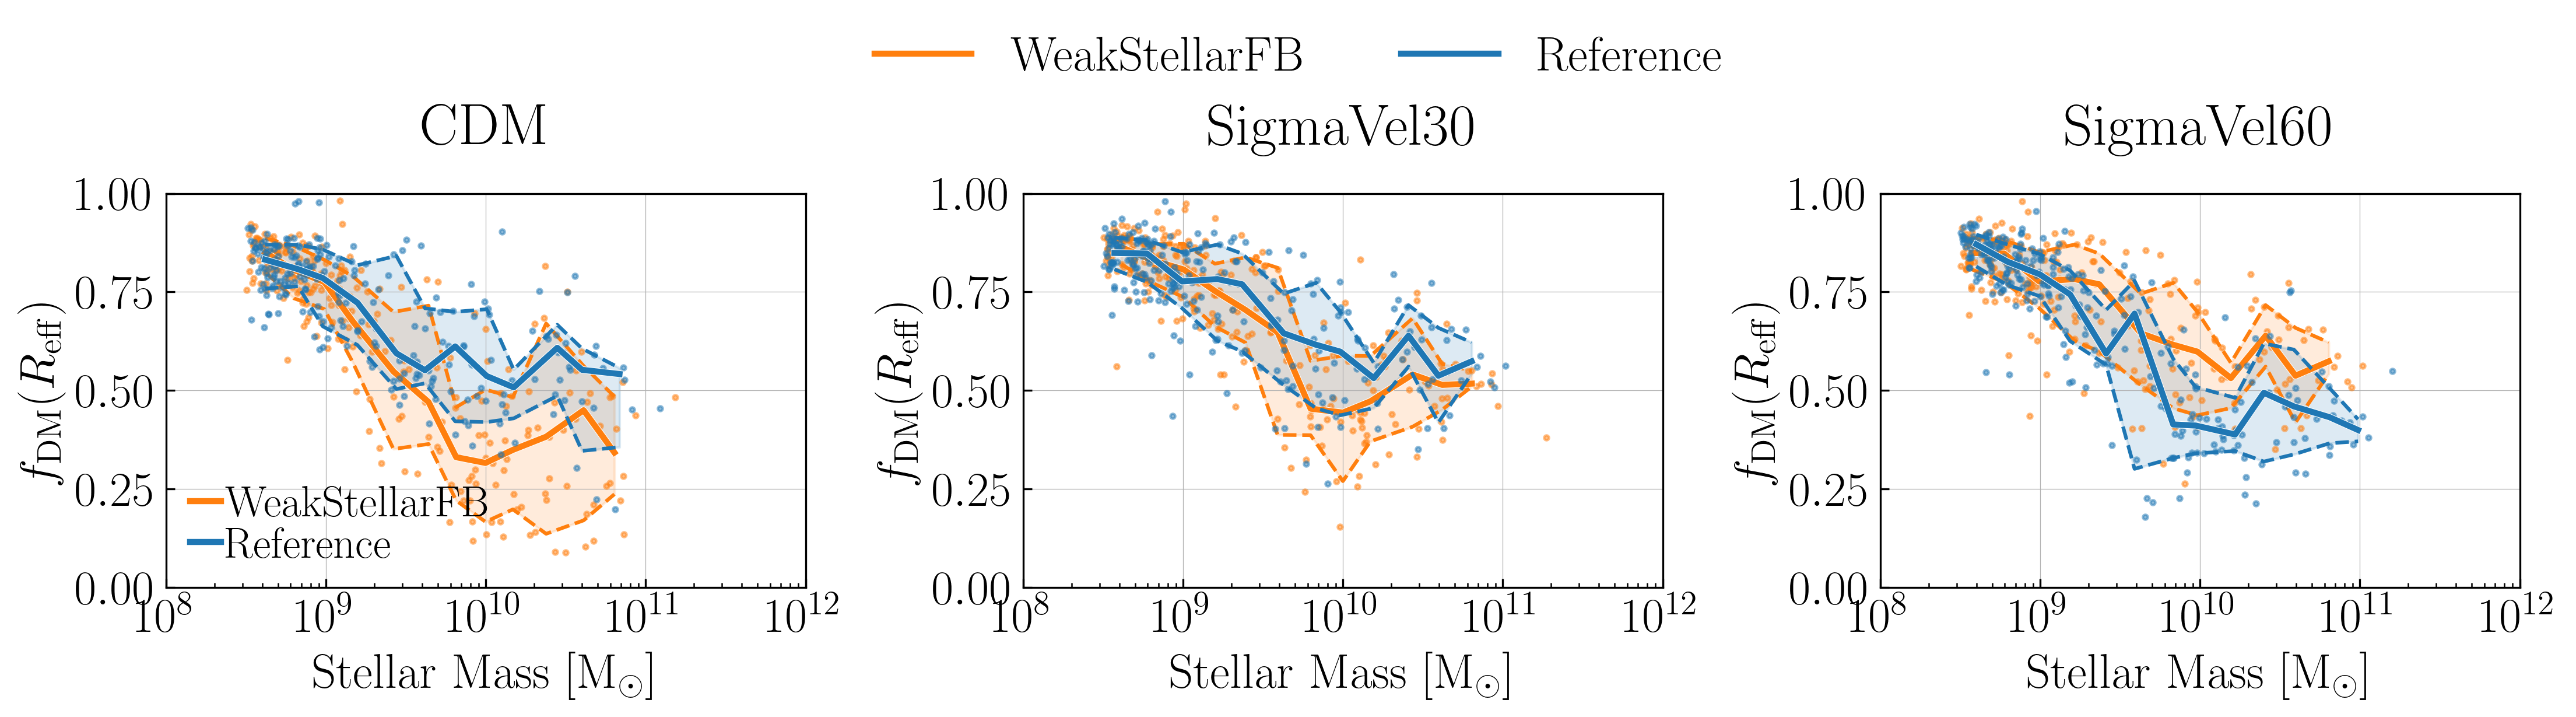

In [18]:
# Define data
files = glob.glob('dataset/*.csv')
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'Reference', 'WeakStellarFB', 'Reference', 'WeakStellarFB', 'Reference'] # Clearer names
titles = ['CDM', 'SigmaVel30', 'SigmaVel60']  # Adding names following Correa+ (2024)
colors = ['tab:orange', 'tab:blue']


fig, axs = plt.subplots(1, 3, figsize=(15, 4), dpi=300) # Increasing resolution

for j, file_path in enumerate(file_paths):
    ax = axs[j // 2]

    halo = classhalo(file_path, type='all')

    M = 10**halo.Mstar
    fDM = halo.fDM
    f = []
    for k in range(len(fDM[0, :])):
        f = np.append(f, np.interp(halo.GalaxyHalfLightRadius[k], halo.Velocity_radial_bins, fDM[:, k]))

    ax.plot(M, f, 'o',  c=colors[j % 2], alpha=0.5)

    bins = np.arange(halo.Mstar.min(), halo.Mstar.max(), 0.2)
    bins = 10**bins
    if j==0 or j==1:
        plot_median_relation(ax, bins, M, f, errorbars=True, color=colors[j % 2], label=file_names[j]) 
    else : 
        plot_median_relation_withoutlabel(ax, bins, M, f, errorbars=True, color=colors[j % 2])  

    
    ax.legend(loc=[0.01, 0.01], labelspacing=0.05, handlelength=0.7, handletextpad=0.1,
              frameon=False, fontsize=18, ncol=1)

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing

    ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([10**8, 10**12])
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j // 2], pad = 20)
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, borderaxespad=0.001, framealpha=0)


plt.tight_layout()
plt.savefig('fDMvsStelM.pdf',  bbox_inches='tight')
plt.savefig('fDMvsStelM.png',  bbox_inches='tight')
plt.show()



## Dark Matter Fraction as a function of the effective radius

/tmp/ipykernel_3395031/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3395031/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/miniconda3/envs/JupyHub2023_novembre/lib/python3.11/site-packages/scipy/stats/_binned_statistic.py:609: RuntimeWarning: invalid value encountered in subtract
  delta = values[vv] - flatsum[binnumbers] / flatcount[binnumbers]
/tmp/ipykernel_3395031/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3395031/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM

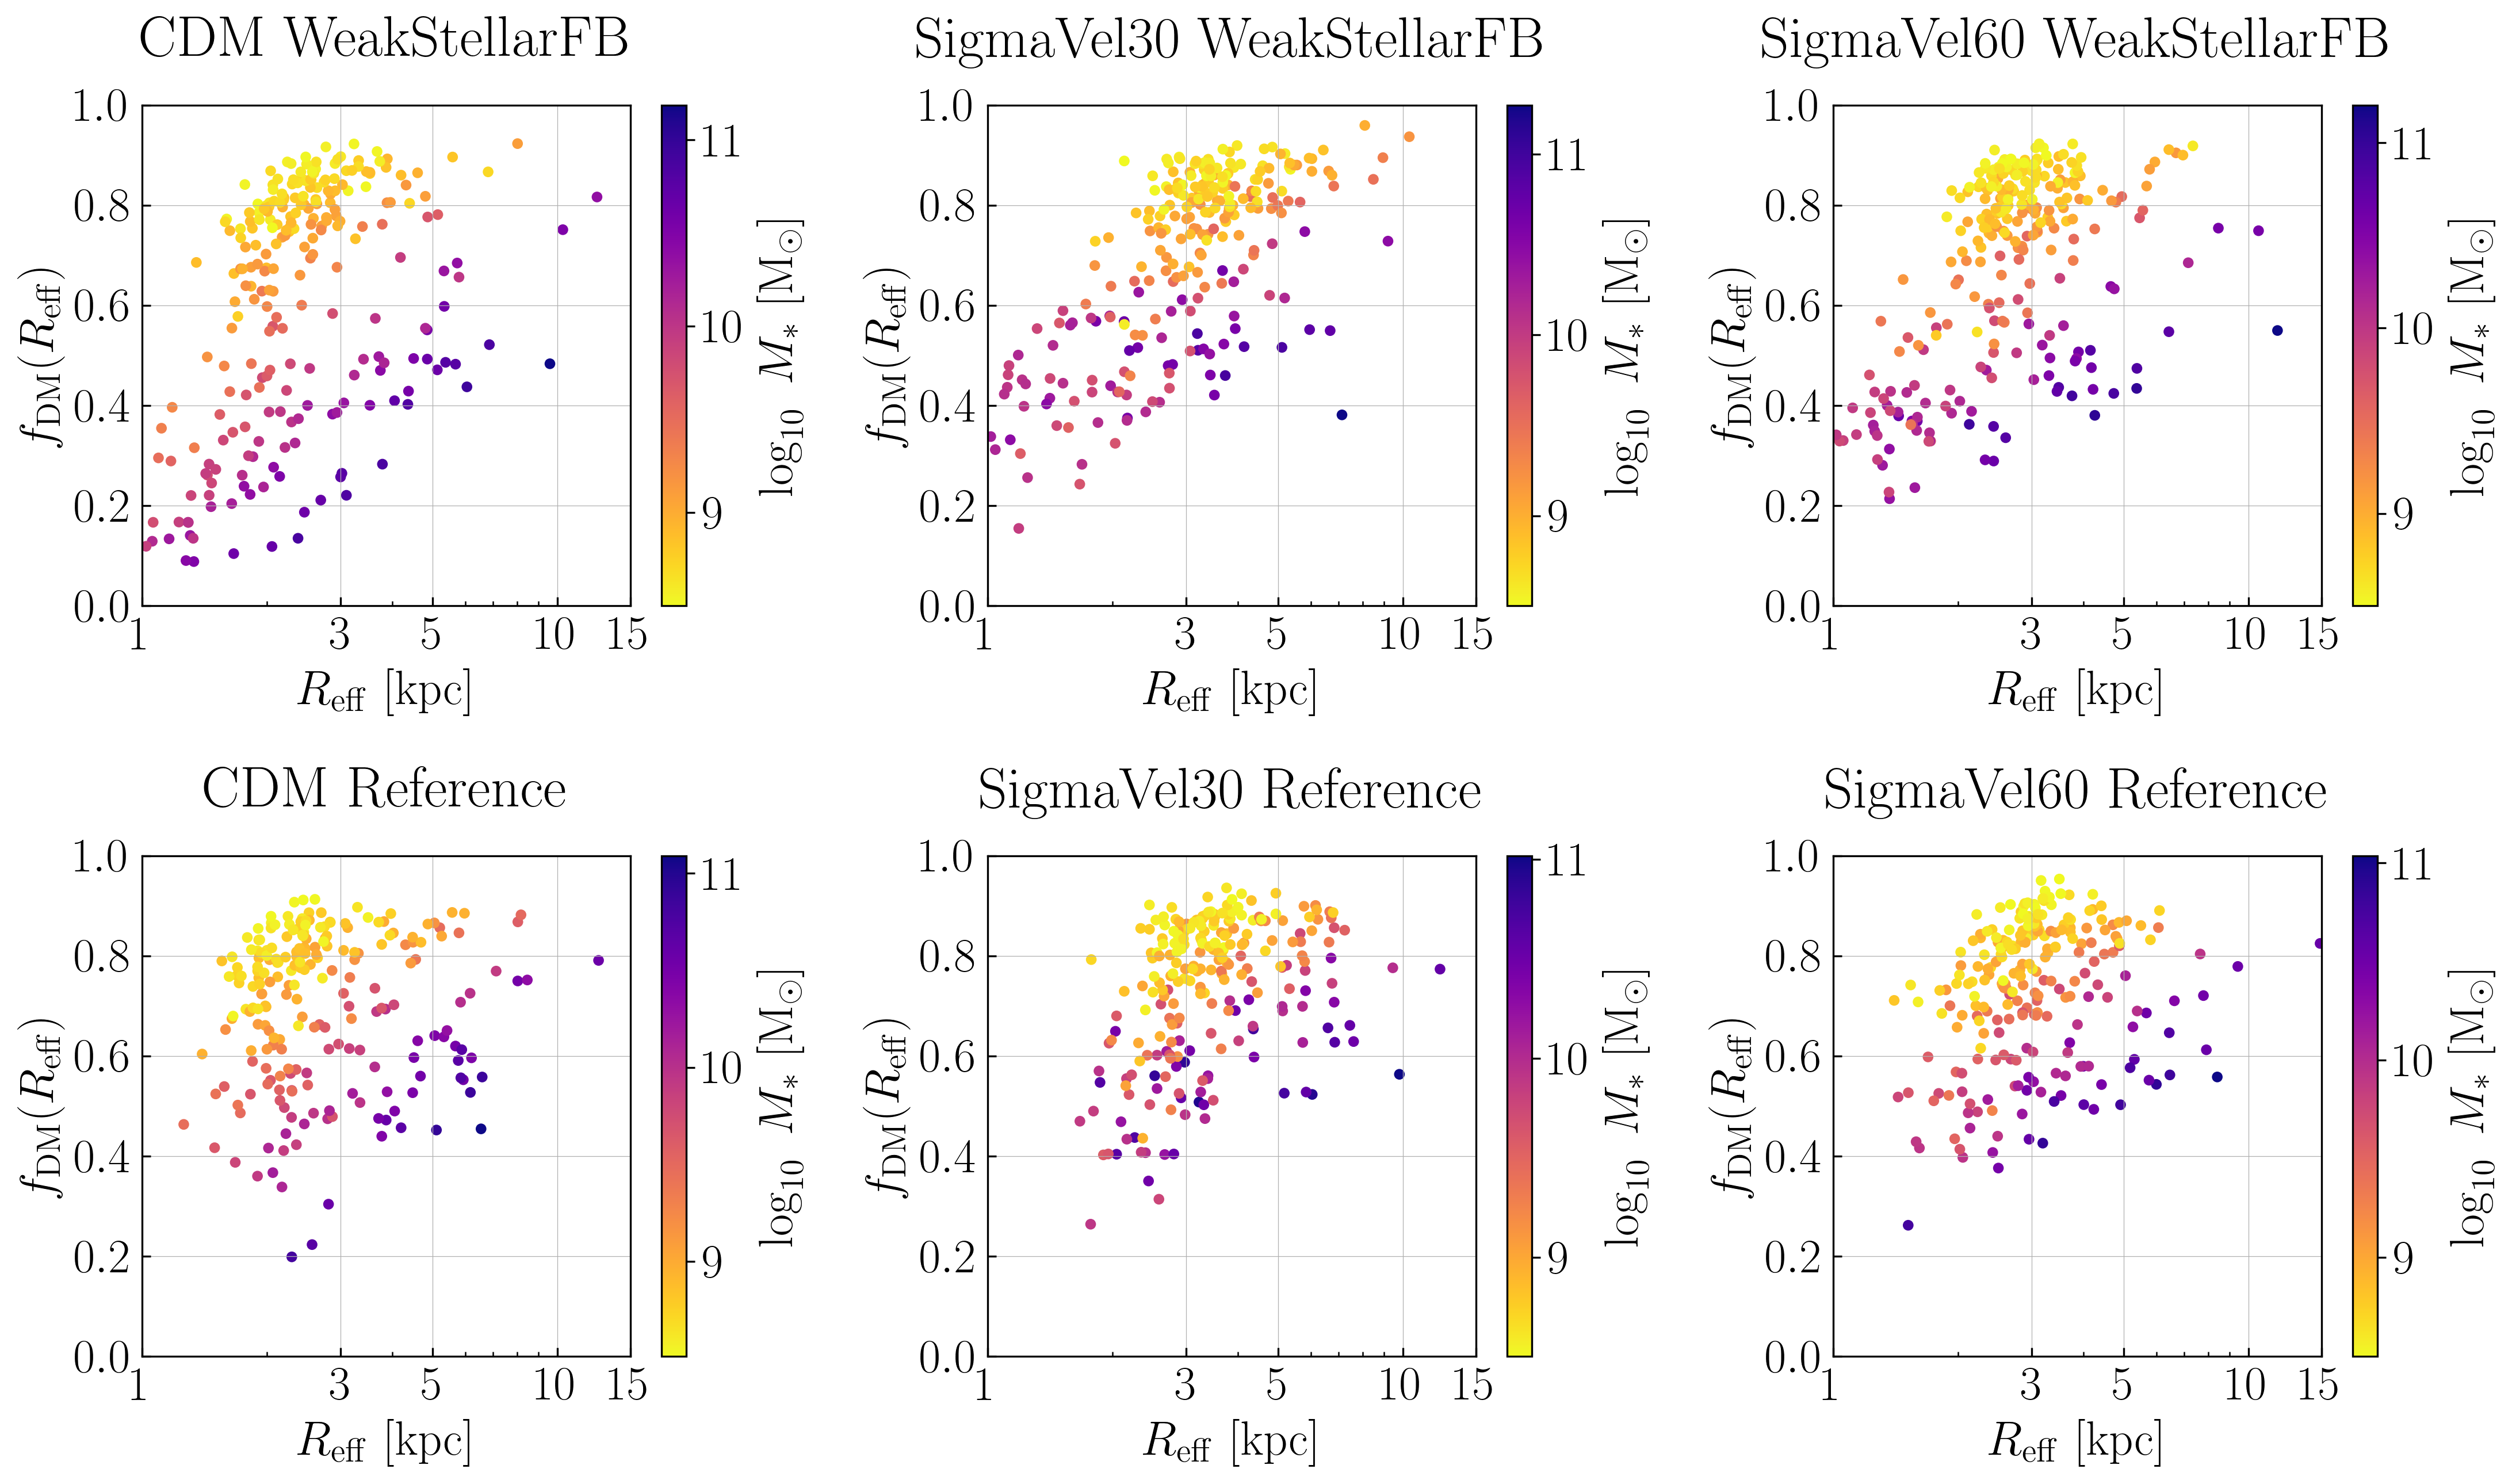

In [5]:
# Define data
file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60'] # Minor changes


fig, axs = plt.subplots(2, 3, figsize=(15, 9), dpi=300) # Increasing resolution (minimum dpi=300 always)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'$R_{\mathrm{eff}}$ [kpc]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([1, 15]) # Better in log-scale 
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

    xticks = np.array([1,3,5,10,15]) # Let's play with the x-ticks
    labels = ["1", "3", "5", "10", "15"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)

    halo = classhalo(file_path, type='all')

    Reff = halo.GalaxyHalfLightRadius
    fDM = halo.fDM
    f = []
    for k in range(len(fDM[0, :])):
        f.append(np.interp(halo.GalaxyHalfLightRadius[k], halo.Velocity_radial_bins, fDM[:, k]))

    sc = ax.scatter(Reff, f, c=halo.Mstar, s=12, cmap = 'plasma_r') # Making points bigger

    if j % 1 == 0:
        plt.colorbar(sc, ax=ax, label = r'$\log_{10}~M_{*}$ [$\mathrm{M}_{\odot}]$') # Here are plotting the log10 of stellar mass, then we make it clear in the colorbar label

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing

    bins = np.arange(halo.GalaxyHalfLightRadius.min(), halo.GalaxyHalfLightRadius.max(), 2)
    
    bin_means, bin_edges, _ = stats.binned_statistic(Reff, f, bins=bins, statistic='median')
    bin_std, _, _ = stats.binned_statistic(Reff, f, bins=bins, statistic='std')

plt.tight_layout()
plt.savefig('fDMvsR.pdf')
plt.savefig('fDMvsR.png')
plt.show()



## Dark Matter Fraction for ellipticals VS disky ones

/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = 

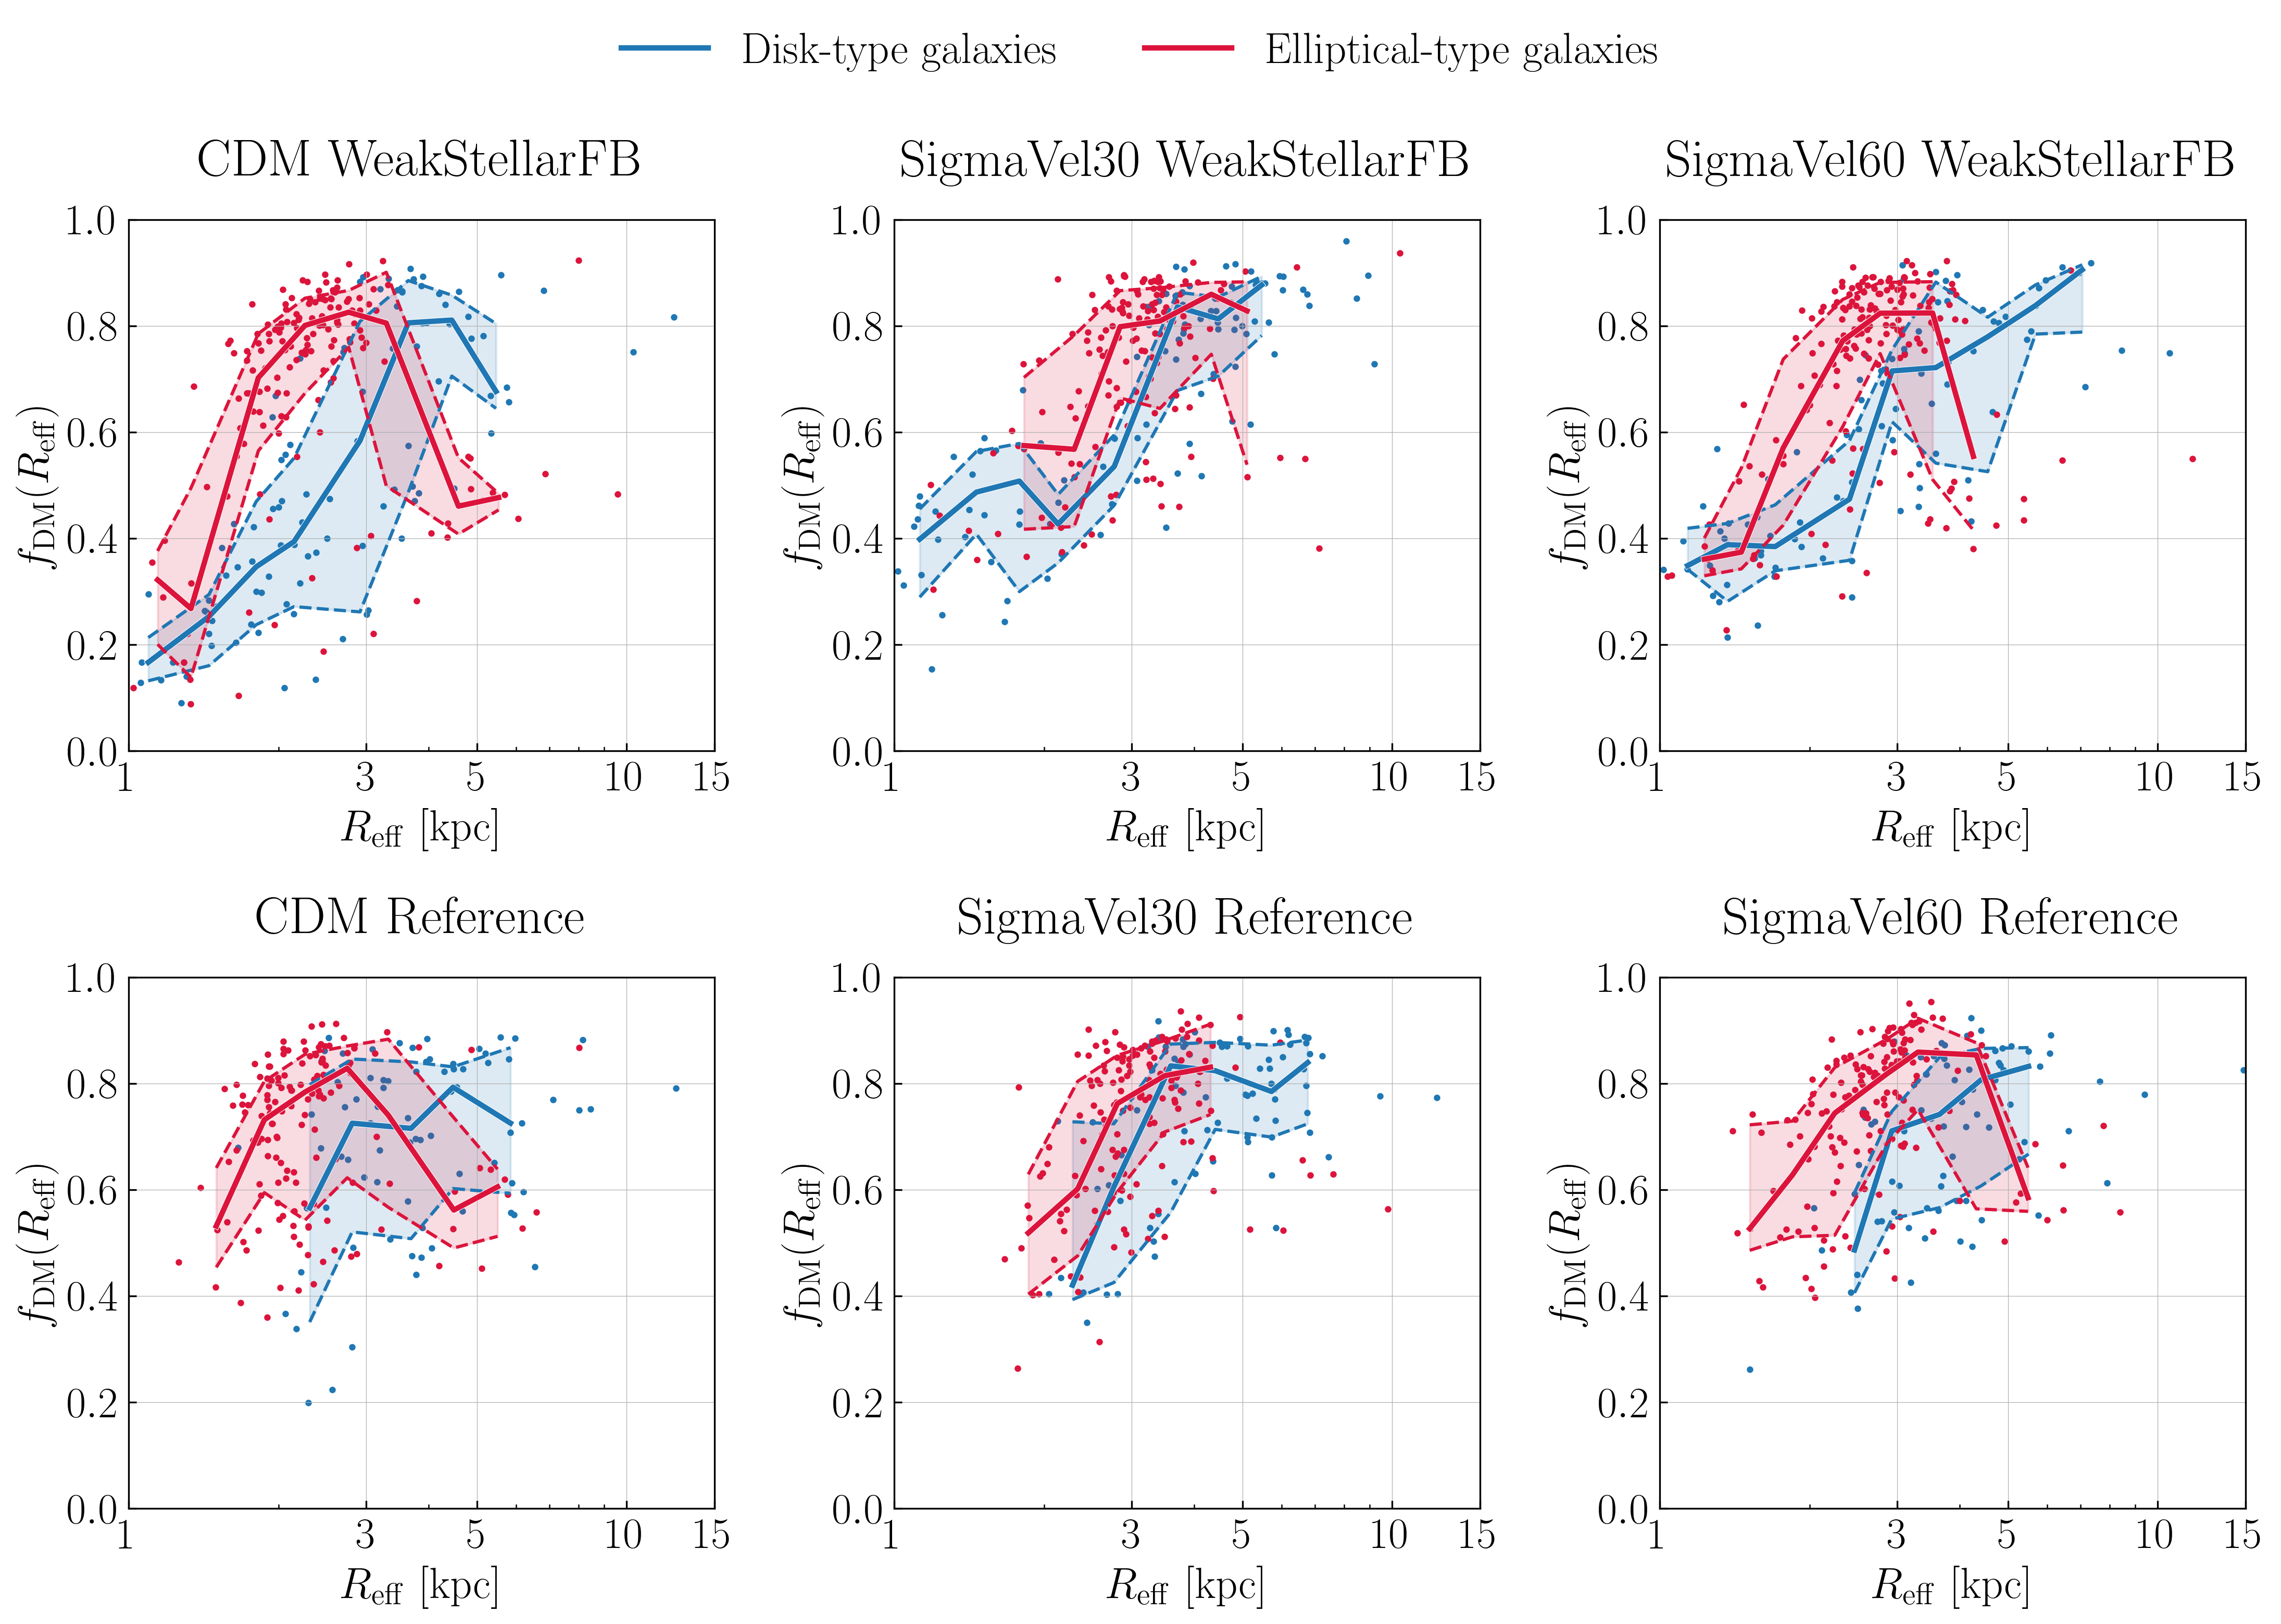

In [17]:
# Define data
maxval = 1e12
minval = 1e8
nb = 0.2


file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60']
#colors = [(174/255, 204/255, 255/255), (1, 63/255, 63/255)]
colors = ['tab:blue','crimson']

# Create figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=300)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'$R_{\mathrm{eff}}$ [kpc]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([1, 8]) # Better in log-scale 
    ax.set_xscale('log')

    xticks = np.array([1,3,5,10,15]) # Let's play with the x-ticks
    labels = ["1", "3", "5", "10", "15"]
    ax.set_xticks(xticks)
    ax.set_xticklabels(labels)
    
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

    # Plot data for disk
    halo_disk = classhalo(file_path, type='disk')
    i = np.where((10**halo_disk.Mstar<maxval) & (10**halo_disk.Mstar>minval))[0]
    Reff_disk = halo_disk.GalaxyHalfLightRadius[i]
    fDM_disk = halo_disk.fDM[:,i]
    f_disk = [np.interp(halo_disk.GalaxyHalfLightRadius[k], halo_disk.Velocity_radial_bins, fDM_disk[:, k]) for k in range(len(fDM_disk[0, :]))]
    f_disk = np.array(f_disk)

    ax.scatter(Reff_disk, f_disk, c=colors[0])  

    bins = np.arange(np.log10(1), np.log10(8), 0.1) # Let's use same binning throughout
    bins = 10**bins
    if j==0:
        plot_median_relation(ax, bins, Reff_disk, f_disk, errorbars=True, color=colors[0], label='Disk-type galaxies') 
    else : 
        plot_median_relation_withoutlabel(ax, bins, Reff_disk, f_disk, errorbars=True, color=colors[0]) 
    
    # bins_disk = np.arange(halo_disk.GalaxyHalfLightRadius.min(), halo_disk.GalaxyHalfLightRadius.max(), nb)
    # bin_means_disk, bin_edges_disk, _ = stats.binned_statistic(Reff_disk, f_disk, bins=bins_disk, statistic='median')
    # bin_std_disk, _, _ = stats.binned_statistic(Reff_disk, f_disk, bins=bins_disk, statistic='std')

    # ax.plot(bin_edges_disk[:-1], bin_means_disk + bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk, linestyle='-', color=colors[0], label='disk')
    # ax.fill_between(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, bin_means_disk + bin_std_disk, alpha=0.1, color=colors[0])

    # Plot data for elliptical
    halo_elliptical = classhalo(file_path, type='elliptical')
    i = np.where((10**halo_elliptical.Mstar<maxval) & (10**halo_elliptical.Mstar>minval))[0]
    Reff_elliptical = halo_elliptical.GalaxyHalfLightRadius[i]
    fDM_elliptical = halo_elliptical.fDM[:,i]
    f_elliptical = [np.interp(halo_elliptical.GalaxyHalfLightRadius[k], halo_elliptical.Velocity_radial_bins, fDM_elliptical[:, k]) for k in range(len(fDM_elliptical[0, :]))]

    ax.scatter(Reff_elliptical, f_elliptical, c=colors[1])
    f_elliptical = np.array(f_elliptical)
    if j==0 :
        plot_median_relation(ax, bins, Reff_elliptical, f_elliptical, errorbars=True, color=colors[1], label='Elliptical-type galaxies')
    else : 
        plot_median_relation_withoutlabel(ax, bins, Reff_elliptical, f_elliptical, errorbars=True, color=colors[1])
    # bins_elliptical = np.arange(halo_elliptical.GalaxyHalfLightRadius.min(), halo_elliptical.GalaxyHalfLightRadius.max(), nb)
    # bin_means_elliptical, bin_edges_elliptical, _ = stats.binned_statistic(Reff_elliptical, f_elliptical, bins=bins_elliptical, statistic='median')
    # bin_std_elliptical, _, _ = stats.binned_statistic(Reff_elliptical, f_elliptical, bins=bins_elliptical, statistic='std')

    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical + bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical, linestyle='-', color=colors[1], label='elliptical')
    # ax.fill_between(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, bin_means_elliptical + bin_std_elliptical, alpha=0.1, color=colors[1])

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, borderaxespad=0.001, framealpha=0)

plt.tight_layout()
plt.savefig('fDMvsR_type.pdf',  bbox_inches='tight')
plt.savefig('fDMvsR_type.png',  bbox_inches='tight')

plt.show()


/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2


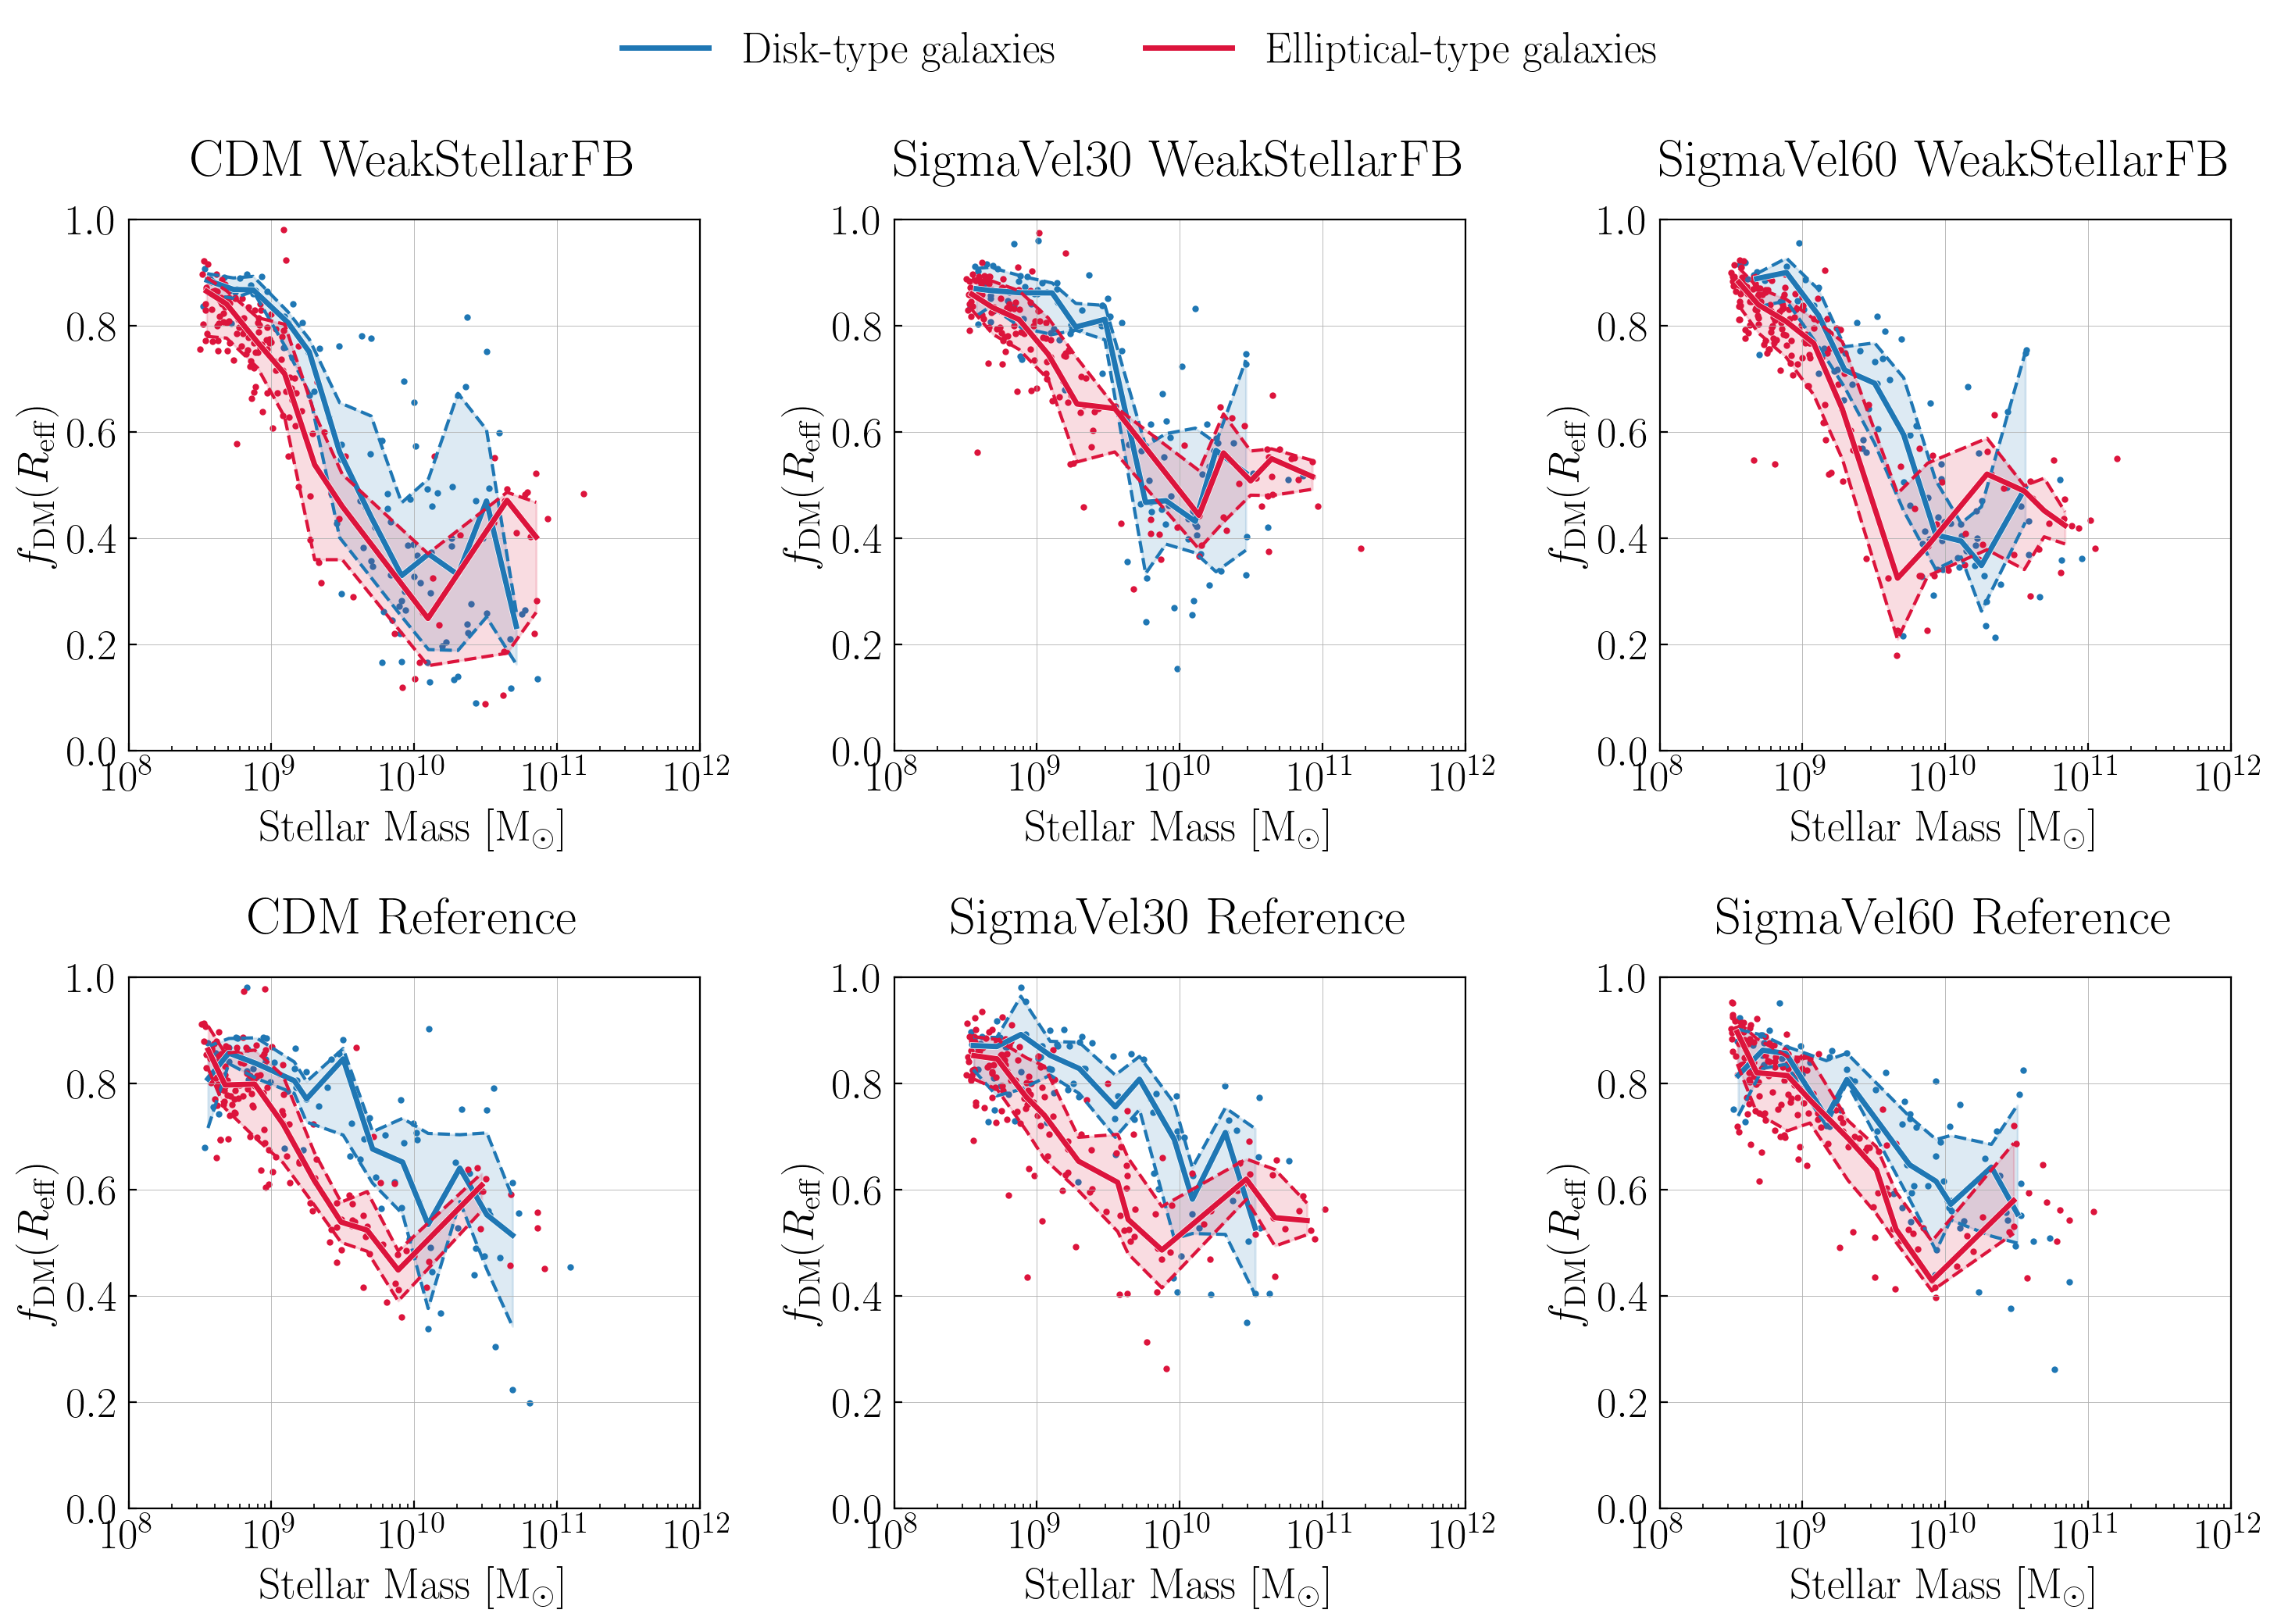

In [16]:
## Define data
maxval = 1e12
minval = 1e8
nb = 0.2


file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60']
colors = ['tab:blue','crimson']

# Create figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=200)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{\mathrm{eff}})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([10**8, 10**12])
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

    # Plot data for disk
    halo_disk = classhalo(file_path, type='disk')
    i = np.where((10**halo_disk.Mstar<maxval) & (10**halo_disk.Mstar>minval))[0]
    M_disk = 10**halo_disk.Mstar[i]
    fDM_disk = halo_disk.fDM[:,i]
    f_disk = [np.interp(halo_disk.GalaxyHalfLightRadius[k], halo_disk.Velocity_radial_bins, fDM_disk[:, k]) for k in range(len(fDM_disk[0, :]))]
    f_disk = np.array(f_disk)

    ax.scatter(M_disk, f_disk, c=colors[0])  

    bins = np.arange(8, 12, 0.2) # Let's use same binning throughout
    bins = 10**bins
    if j==0:
        plot_median_relation(ax, bins, M_disk, f_disk, errorbars=True, color=colors[0], label='Disk-type galaxies') 
    else : 
        plot_median_relation_withoutlabel(ax, bins,M_disk, f_disk, errorbars=True, color=colors[0]) 
    # bins_disk = 10**np.arange(halo_disk.Mstar.min(), halo_disk.Mstar.max(), nb)
    # bin_means_disk, bin_edges_disk, _ = stats.binned_statistic(M_disk, f_disk, bins=bins_disk, statistic='median')
    # bin_std_disk, _, _ = stats.binned_statistic(M_disk, f_disk, bins=bins_disk, statistic='std')

    # ax.plot(bin_edges_disk[:-1], bin_means_disk + bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk, linestyle='-', color=colors[0], label='disk')
    # ax.fill_between(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, bin_means_disk + bin_std_disk, alpha=0.1, color=colors[0])

    # Plot data for elliptical
    halo_elliptical = classhalo(file_path, type='elliptical')
    i = np.where((10**halo_elliptical.Mstar<maxval) & (10**halo_elliptical.Mstar>minval))[0]
    M_elliptical = 10**halo_elliptical.Mstar[i]
    fDM_elliptical = halo_elliptical.fDM[:,i]
    f_elliptical = [np.interp(halo_elliptical.GalaxyHalfLightRadius[k], halo_elliptical.Velocity_radial_bins, fDM_elliptical[:, k]) for k in range(len(fDM_elliptical[0, :]))]
    f_elliptical = np.array(f_elliptical)
    
    ax.scatter(M_elliptical, f_elliptical, c=colors[1]) 
    if j==0:
        plot_median_relation(ax, bins, M_elliptical, f_elliptical, errorbars=True, color=colors[1], label='Elliptical-type galaxies') 
    else : 
        plot_median_relation_withoutlabel(ax, bins, M_elliptical, f_elliptical, errorbars=True, color=colors[1])     # bins_elliptical = 10**np.arange(halo_elliptical.Mstar.min(), halo_elliptical.Mstar.max(), nb)
    # bin_means_elliptical, bin_edges_elliptical, _ = stats.binned_statistic(M_elliptical, f_elliptical, bins=bins_elliptical, statistic='median')
    # bin_std_elliptical, _, _ = stats.binned_statistic(M_elliptical, f_elliptical, bins=bins_elliptical, statistic='std')

    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical + bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical, linestyle='-', color=colors[1], label='elliptical')
    # ax.fill_between(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, bin_means_elliptical + bin_std_elliptical, alpha=0.1, color=colors[1])

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing
    
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, borderaxespad=0.001, framealpha=0)

plt.tight_layout()
plt.savefig('fDMvsM_type.pdf',  bbox_inches='tight')
plt.savefig('fDMvsM_type.png',  bbox_inches='tight')

plt.show()


/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = 

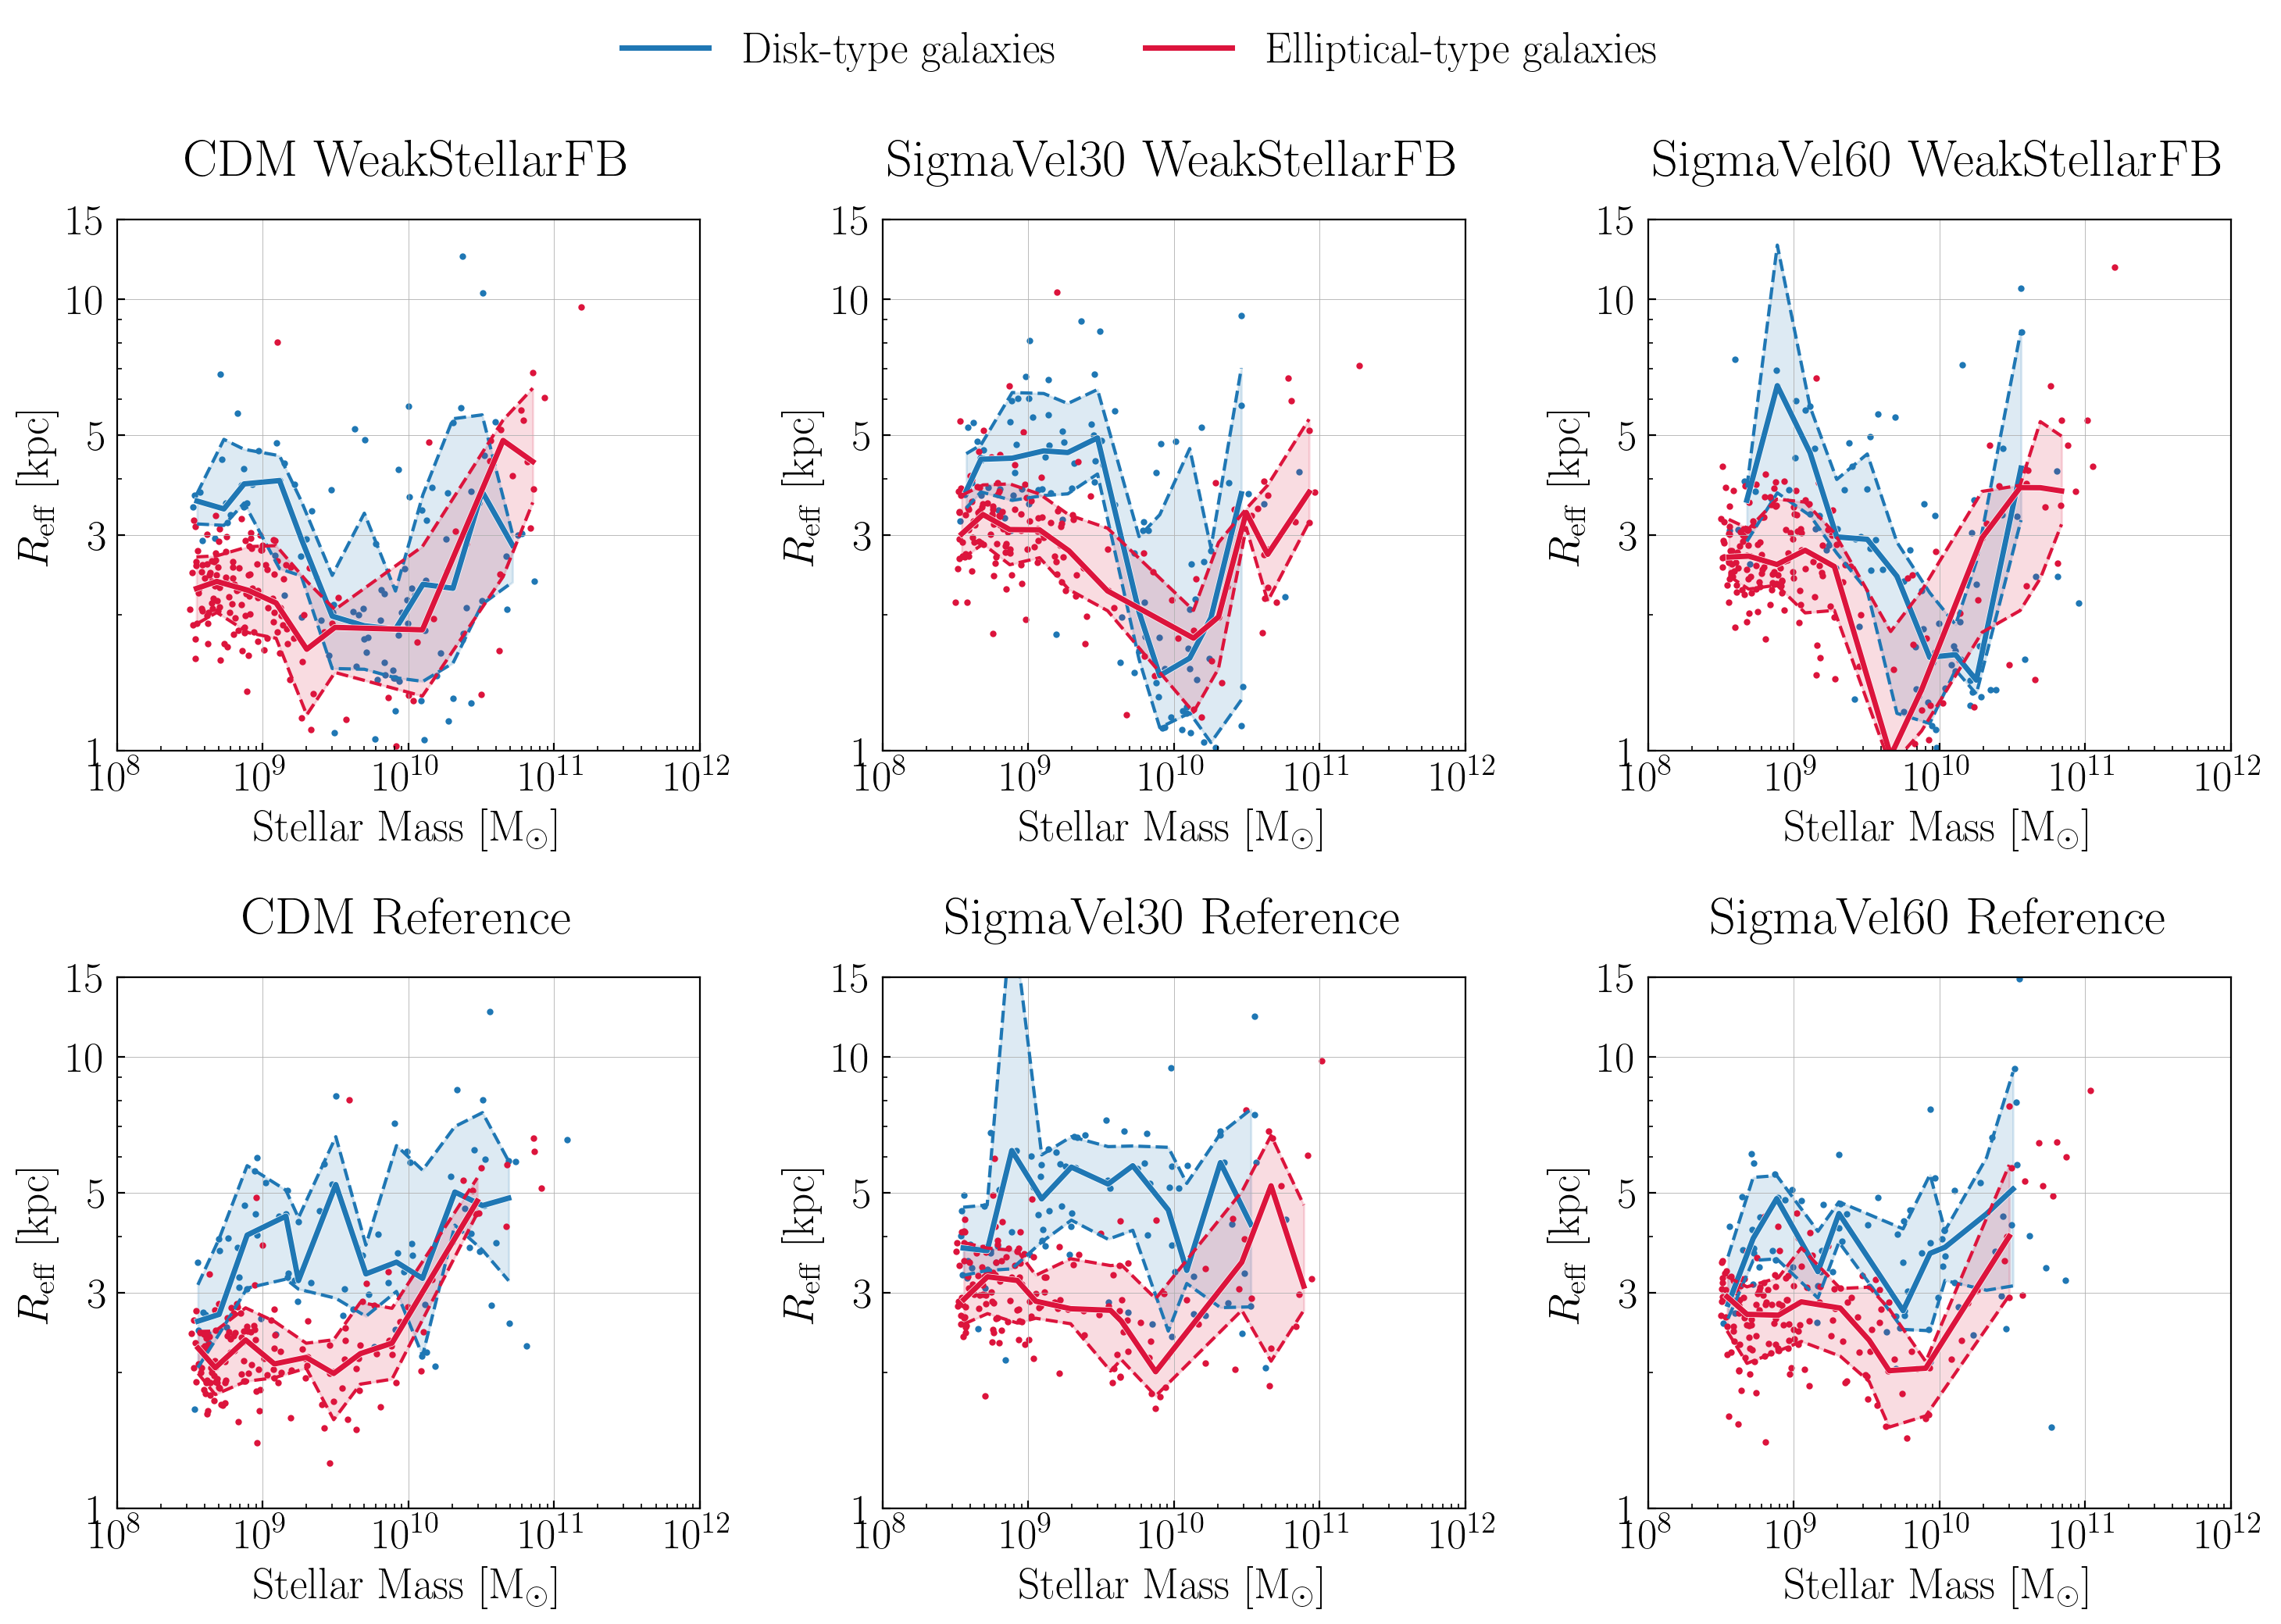

In [15]:
## Define data
maxval = 1e12
minval = 1e8
nb = 0.2


file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60']
#colors = [(174/255, 204/255, 255/255), (1, 63/255, 63/255)] 
colors = ['tab:blue','crimson']
# Create figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=200)

for j, file_path in enumerate(file_paths):
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    ax.set_xlabel(r'Stellar Mass [$\mathrm{M}_{\odot}$]')
    ax.set_ylabel(r'$R_{\mathrm{eff}}$ [kpc]')
    ax.set_ylim([1, 15])
    ax.set_xlim([10**8, 10**12])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    xticks = np.array([1,3,5,10,15]) # Let's play with the x-ticks
    labels = ["1", "3", "5", "10", "15"]
    ax.set_yticks(xticks)
    ax.set_yticklabels(labels)
    ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

    # Plot data for disk
    halo_disk = classhalo(file_path, type='disk')
    i = np.where((10**halo_disk.Mstar<maxval) & (10**halo_disk.Mstar>minval))[0]
    M_disk = 10**halo_disk.Mstar[i]
    Reff_disk = halo_disk.GalaxyHalfLightRadius[i]


    ax.scatter(M_disk, Reff_disk, c=colors[0])  

    bins = np.arange(8, 12, 0.2) # Let's use same binning throughout
    bins = 10**bins
    if j==0:
        plot_median_relation(ax, bins, M_disk, Reff_disk, errorbars=True, color=colors[0], label='Disk-type galaxies') 
    else : 
        plot_median_relation_withoutlabel(ax, bins,M_disk, Reff_disk, errorbars=True, color=colors[0]) 
    # bins_disk = 10**np.arange(halo_disk.Mstar.min(), halo_disk.Mstar.max(), nb)
    # bin_means_disk, bin_edges_disk, _ = stats.binned_statistic(M_disk, f_disk, bins=bins_disk, statistic='median')
    # bin_std_disk, _, _ = stats.binned_statistic(M_disk, f_disk, bins=bins_disk, statistic='std')

    # ax.plot(bin_edges_disk[:-1], bin_means_disk + bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, '--', color=colors[0], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_disk[:-1], bin_means_disk, linestyle='-', color=colors[0], label='disk')
    # ax.fill_between(bin_edges_disk[:-1], bin_means_disk - bin_std_disk, bin_means_disk + bin_std_disk, alpha=0.1, color=colors[0])

    # Plot data for elliptical
    halo_elliptical = classhalo(file_path, type='elliptical')
    i = np.where((10**halo_elliptical.Mstar<maxval) & (10**halo_elliptical.Mstar>minval))[0]
    M_elliptical = 10**halo_elliptical.Mstar[i]
    Reff_elliptical = halo_elliptical.GalaxyHalfLightRadius[i]

    
    ax.scatter(M_elliptical, Reff_elliptical, c=colors[1]) 
    if j==0:
        plot_median_relation(ax, bins, M_elliptical, Reff_elliptical, errorbars=True, color=colors[1], label='Elliptical-type galaxies') 
    else : 
        plot_median_relation_withoutlabel(ax, bins,M_elliptical, Reff_elliptical, errorbars=True, color=colors[1])     # bins_elliptical = 10**np.arange(halo_elliptical.Mstar.min(), halo_elliptical.Mstar.max(), nb)
    # bin_means_elliptical, bin_edges_elliptical, _ = stats.binned_statistic(M_elliptical, f_elliptical, bins=bins_elliptical, statistic='median')
    # bin_std_elliptical, _, _ = stats.binned_statistic(M_elliptical, f_elliptical, bins=bins_elliptical, statistic='std')

    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical + bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, '--', color=colors[1], linewidth=0.8, alpha=0.2)
    # ax.plot(bin_edges_elliptical[:-1], bin_means_elliptical, linestyle='-', color=colors[1], label='elliptical')
    # ax.fill_between(bin_edges_elliptical[:-1], bin_means_elliptical - bin_std_elliptical, bin_means_elliptical + bin_std_elliptical, alpha=0.1, color=colors[1])

    ax.tick_params(direction='in', axis='both', which='both', pad=4.5) # Minor thing

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, borderaxespad=0.001, framealpha=0)

plt.tight_layout()
plt.savefig('ReffvsM_type.pdf',  bbox_inches='tight')
plt.savefig('ReffvsM_type.png', bbox_inches='tight')

plt.show()


## Comparison with observational data

/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: invalid value encountered in divide
  self.fDM = (profile_data_group["Dark_matter_Circular_Velocity"][:,select]/profile_data_group["Circular_Velocity"][:,select])**2
/tmp/ipykernel_3399089/2769655278.py:99: RuntimeWarning: divide by zero encountered in divide
  self.fDM =

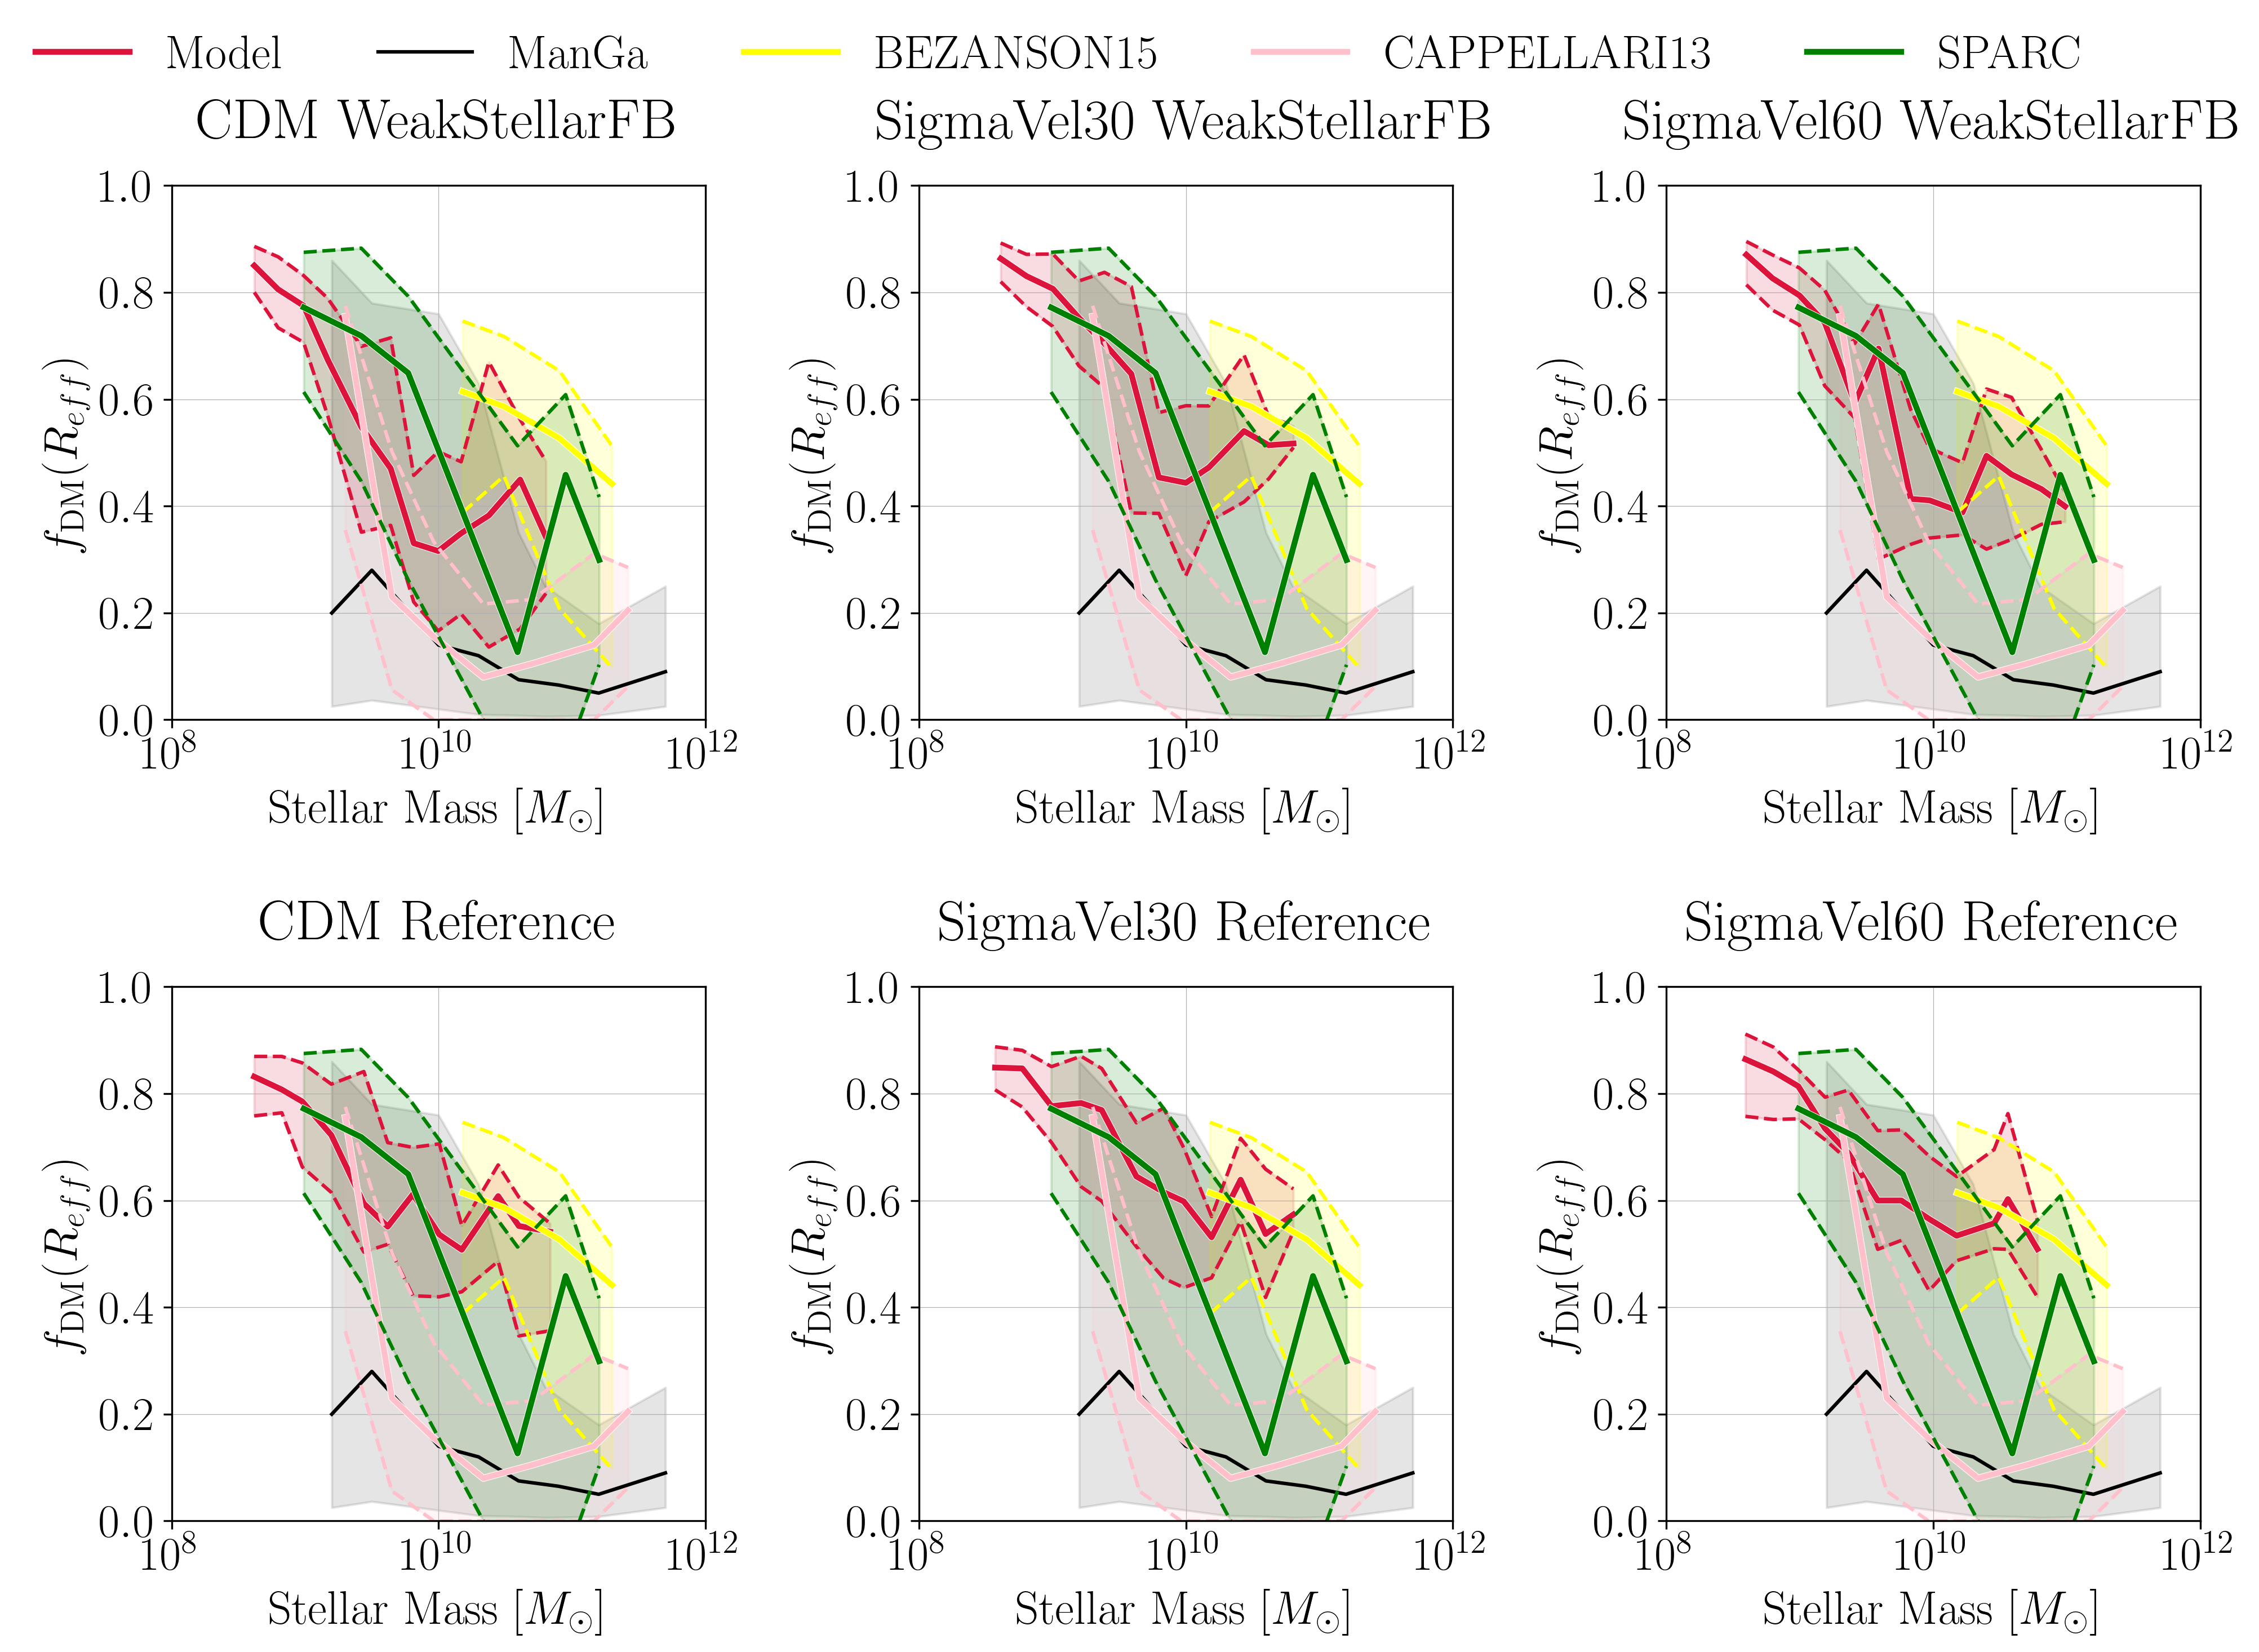

In [14]:
files = glob.glob('dataset/*.csv')
tab = np.array([0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 19, 21, 23, 25, 26, 27, 30, 
                31, 33, 35, 38, 39, 40, 41, 50, 51, 52, 53, 57, 58, 59, 61, 64, 68, 75, 78, 79,
                81, 83, 84, 87, 89, 90, 91, 92, 93, 94, 95, 97, 99])

file_paths = ['Halo_data_L025N376WeakStellarFBSigmaConstant00.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep30Anisotropic.hdf5',
              'Halo_data_L025N376WeakStellarFBSigmaVelDep60Anisotropic.hdf5',
              'Halo_data_L025N376ReferenceSigmaConstant00.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep30Anisotropic.hdf5', 
              'Halo_data_L025N376ReferenceSigmaVelDep60Anisotropic.hdf5']

file_names = ['WeakStellarFB', 'WeakStellarFB', 'WeakStellarFB', 'Reference', 'Reference', 'Reference']
titles = ['CDM', 'SigmaVel30', 'SigmaVel60', 'CDM', 'SigmaVel30', 'SigmaVel60']
#colors = [(174/255, 204/255, 255/255), (1, 63/255, 63/255)]


# Create figure with 6 subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=300)
plt.subplots_adjust(hspace=0.5, wspace=0.4)
for j, file_path in enumerate(file_paths):
    colors = ['tab:blue','crimson']
    row = j // 3
    col = j % 3

    ax = axs[row, col]


    halo = classhalo(file_path, type='all')

    M = 10**halo.Mstar
    fDM = halo.fDM
    f = []
    for k in range(len(fDM[0, :])):
        f = np.append(f, np.interp(halo.GalaxyHalfLightRadius[k], halo.Velocity_radial_bins, fDM[:, k]))

    #ax.plot(M, f, 'o',  c=colors[j % 2], alpha=0.5)

    bins = np.arange(halo.Mstar.min(), halo.Mstar.max(), 0.2)
    bins = 10**bins

    if j==0:
        plot_median_relation(ax, bins, M, f, errorbars=True, color=colors[1], label = 'Model') 
    else : 
        plot_median_relation_withoutlabel(ax, bins, M, f, errorbars=True, color=colors[1]) 

    ax.set_xlabel(r'Stellar Mass [$M_{\odot}$]')
    ax.set_ylabel(r'$f_{\mathrm{DM}}(R_{eff})$')
    ax.set_ylim([0, 1])
    ax.set_xlim([10**8, 10**12])
    ax.set_xscale('log')
    ax.grid(linestyle='-', linewidth=0.3)
    ax.set_title(titles[j] + ' ' + file_names[j], pad = 20)

    ######## Obs
    if j % 1 == 0:
        ############## Manga dataset
        M = 10**np.array([9.2,9.5,10,10.3,10.6,10.9,11.2,11.7])
        f = np.array([0.2,0.28,0.14,0.12,0.075,0.065,0.05,0.09])
        
        if j==0:
            ax.plot(M, f,  c='black', linestyle='-',  label = 'ManGa')
        else : 
            ax.plot(M, f,  c='black', linestyle='-')
        x1 = 10**np.array([9.2,9.5,10,10.3,10.6,10.8,11.2,11.7])
        x2 = 10**np.array([9.2,9.7,10,10.3,10.9,11.5,11.7])
        y1 = np.array([0.86,0.78,0.76,0.63,0.35,0.25,0.18,0.25])
        y2 = np.array([0.025,0.05,0.02,0.01,0.005,0.015,0.025])
        y2_interp = np.interp(x1, x2, y2)
        ax.fill_between(x1, y1, y2_interp, alpha=0.1, color='black')
        
        for k, file_path in enumerate(files):
            colors = ['yellow', 'pink', 'green']
            file_path = files[k]
            name = file_path.split('/')[-1].split('.')[0]
            df = pd.read_csv(file_path)
            M = np.float64(np.array(df["M*"].iloc[1:].values))
            fDMReff = np.array(df['fDM(Reff)'].iloc[1:].values)
            sigma_fdmReff = np.array(df['sigma_fdm(Reff)'].iloc[1:].values)
            # Adding the transformation from Salpeter IMF to Chabrier.
            if name == 'CAPPELLARI13':
                M = 10**(np.log10(M)-0.25)
            if name == 'SPARC':
                M = M[tab]
                fDMReff = fDMReff[tab]
                sigma_fdmReff = sigma_fdmReff[tab]
            bins = np.arange(np.log10(M.min()), np.log(M.max()), 0.4)
            bins = 10**bins
            if j==0:
                plot_median_relation(ax, bins, M, fDMReff, errorbars=True, color=colors[k], label=name)            
            else : 
                plot_median_relation_withoutlabel(ax, bins, M, fDMReff, errorbars=True, color=colors[k])

fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, borderaxespad=0.000001, framealpha=0)


plt.savefig('obs_fDMvsStelM.pdf',  bbox_inches='tight')

plt.savefig('obs_fDMvsStelM.png',  bbox_inches='tight')

plt.show()
